# TODO

- Sort paths by start point nearest last end point
- Calibrate pen size for filling by zig-zag pattern
- Put filling code into pltme-driver

In [513]:
%pylab inline
import io
import subprocess
import pathlib

Populating the interactive namespace from numpy and matplotlib


/home/moe/.virtualenvs/sci3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [514]:
PSTOEDIT_CMD = '/home/moe/dev/plotter/pstoedit/prefix/bin/pstoedit'
#SRC_SVG_PATH = '/home/moe/dev/plotter/pstoedit/prefix/bin/r.svg'
SRC_SVG_PATH = str(pathlib.Path('~/tmp/soyuz.svg').expanduser())

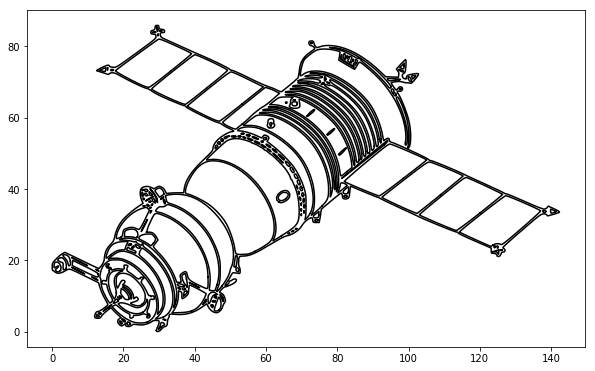

In [515]:
subprocess.check_call(['cairosvg',SRC_SVG_PATH,'-o','r.ps'])
subprocess.check_call([PSTOEDIT_CMD, '-f', 'plotme', 'r.ps', '-o', 'r.pltme'])
#print('\n'.join('{}'.format(l) for l in raw.splitlines()))

with io.open('r.pltme') as f:
    raw = f.read()

figure(figsize=(10,10))
xx = []
yy = []

def output():
    global xx, yy
    if not xx:
        return
    plot(xx, yy, '-k')
    xx = []
    yy = []

for line in raw.splitlines():
    parts = line.strip().split(';')
    cmd = parts[0].upper()
    if cmd == 'PATH':
        output()
    elif cmd == 'MOVETO':
        output()
        xx = [ float(parts[1]) ]
        yy = [ float(parts[2]) ]
    elif cmd == 'LINETO':
        xx.append(float(parts[1]))
        yy.append(float(parts[2]))
    else:
        raise RuntimeError('Unexpected cmd `{}`'.format(cmd))
        
output()

gca().set_aspect('equal')

In [554]:
class Path(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def translate(self, dx, dy):
        return Path(x=np.asanyarray(self.x)+dx,
                    y=np.asanyarray(self.y)+dy)
    
    def length(self):
        dx = np.diff(self.x)
        dy = np.diff(self.y)
        hh = np.hypot(dx,dy)
        return np.sum(hh)
    
    def start(self):
        return self.x[0], self.y[0]
    
    def end(self):
        return self.x[-1], self.y[-1]
    
    def minmax_x(self):
        return min(p.x), max(p.x)
    
    def minmax_y(self):
        return min(p.y), max(p.y)
    
    def width(self):
        min_x, max_x = self.minmax_x()
        return max_x - min_x
    
    def height(self):
        min_y, max_y = self.minmax_y()
        return max_y - min_y
    
    def __str__(self):
        return '<Path N={} L={}>'.format(len(self.x), self.length())
    
    __repr__ = __str__
        
class PathCollection(object):
    def __init__(self, paths):
        self.paths = paths
    
    def minmax_x(self):
        min_x = min(min(p.x) for p in self.paths)
        max_x = max(max(p.x) for p in self.paths)
        return min_x, max_x
    
    def minmax_y(self):
        min_y = min(min(p.y) for p in self.paths)
        max_y = max(max(p.y) for p in self.paths)
        return min_y, max_y
    
    def width(self):
        min_x, max_x = self.minmax_x()
        return max_x - min_x
    
    def height(self):
        min_y, max_y = self.minmax_y()
        return max_y - min_y
    
    def translate(self, dx, dy):
        return PathCollection([p.translate(dx, dy) for p in self.paths])

    def translate_to_origin(self):
        min_x = min(min(p.x) for p in self.paths)
        min_y = min(min(p.y) for p in self.paths)
        translated_paths = [ p.translate(-min_x,-min_y) for p in self.paths ]
        return PathCollection(translated_paths)

39


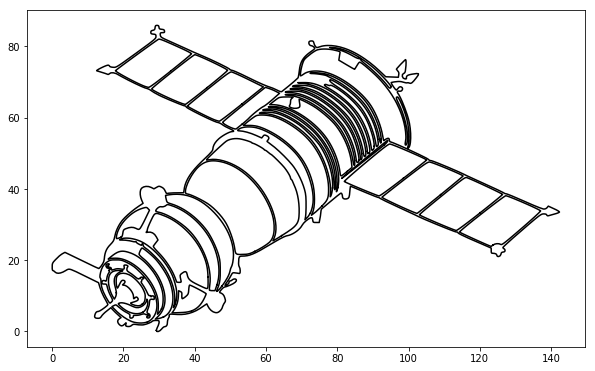

In [520]:
def parse(file_path):
    with io.open(file_path) as f:
        raw = f.read()
    
    paths = []

    xx = []
    yy = []

    def output():
        nonlocal xx, yy
        if not xx:
            return
        paths.append(Path(xx[::], yy[::]))
        xx = []
        yy = []

    for line in raw.splitlines():
        parts = line.strip().split(';')
        cmd = parts[0].upper()
        if cmd == 'PATH':
            output()
        elif cmd == 'MOVETO':
            output()
            xx = [ float(parts[1]) ]
            yy = [ float(parts[2]) ]
        elif cmd == 'LINETO':
            xx.append(float(parts[1]))
            yy.append(float(parts[2]))
        else:
            raise RuntimeError('Unexpected cmd `{}`'.format(cmd))
    output()
    
    return PathCollection(paths=paths)
    
def display(paths):
    figure(figsize=(10,10))
    for p in paths:
        plot(p.x, p.y, '-k')
    gca().set_aspect('equal')
    

path_coll = parse('r.pltme').translate_to_origin()
path_coll_filtered = PathCollection([p for p in path_coll.paths if p.length()>20])
print(len(path_coll_filtered.paths))
display(path_coll_filtered.paths)

In [521]:
plater_xx = [10,200]
plater_yy = [60,200]

plater_width = float(np.abs(np.diff(plater_xx)))
plater_height = float(np.abs(np.diff(plater_yy)))
plater_mid_x = float(np.mean(plater_xx))
plater_mid_y = float(np.mean(plater_yy))

print('PLATER w =',plater_width, 'h =',plater_height)

if path_coll.width() > plater_width or path_coll.height() > plater_height:
    raise RuntimeError('Drawing too big for plater')
else:
    print('Drawing size is OK: w={}, h={}'.format(path_coll.width(), path_coll.height()))
    
path_coll = path_coll.translate_to_origin().translate(min(plater_xx), min(plater_yy))

PLATER w = 190.0 h = 140.0
Drawing size is OK: w=142.34, h=85.8974984


In [617]:
engage_z = 40
pen_up_z = 18
pen_down_z = 17

#engage_z = 40
#pen_up_z = 28
#pen_down_z = 25

def emit_preface():
    # Set units to mm
    yield 'G21'
    # Absolute positioning
    yield 'G90'
    # Home
    yield 'G28'

def emit_engage():
    # Go to safe height
    yield 'G0 Z{}'.format(engage_z)
    # Move to plater center
    yield 'G0 X{} Y{} F50000'.format(plater_mid_x, plater_mid_y)
    # Move pen to standby height
    yield 'G0 Z{}'.format(pen_up_z)
    
def emit_paths(paths):
    for p in paths:
        # Move pen to standby height
        yield 'G0 Z{}'.format(pen_up_z)
        it = zip(p.x, p.y)
        # Move to first point with pen up
        x,y = next(it)
        yield 'G0 X{} Y{} F50000'.format(x,y)
        # Move pen down
        yield 'G0 Z{}'.format(pen_down_z)
        # Draw connected lines
        for x,y in it:
            yield 'G0 X{} Y{} F50000'.format(x,y)
        # Move pen to standby height
        yield 'G0 Z{}'.format(pen_up_z)
        
def emit_disengage():
    yield 'G0 Z{}'.format(engage_z)
    yield 'G0 X190 Y199 F9999'
            
    
def gen_gcode(paths):
    yield from emit_preface()
    yield from emit_engage()
    yield from emit_paths(paths)
    yield from emit_disengage()
    
gcode_lines = list(gen_gcode(path_coll.paths))

with open('r.gcode', 'w') as f:
    f.writelines(l+'\n' for l in gcode_lines)
print('DONE')

DONE


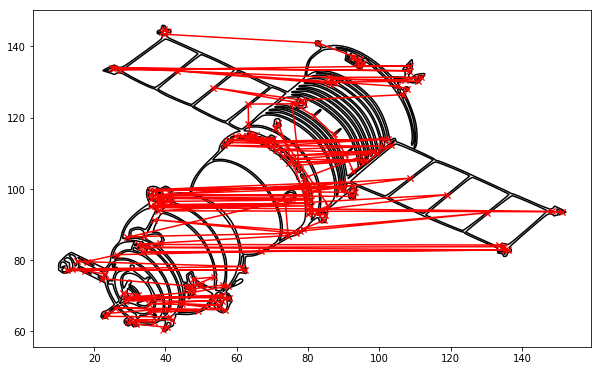

In [547]:
def draw_pen_up_moves(path_coll):
    xx = []
    yy = []
    for p1, p2 in zip(path_coll.paths[:-1], path_coll.paths[1:]):
        # Last point current path to first point next path
        xx += p1.x[-1], p2.x[0]
        yy += p1.y[-1], p2.y[0]
    plot(xx,yy,'x-r')
    
display(path_coll.paths)
draw_pen_up_moves(path_coll)

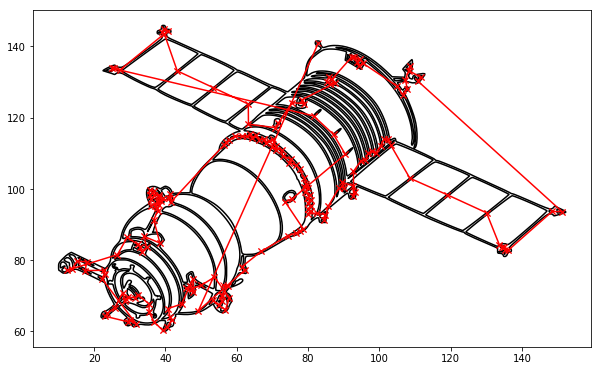

In [548]:
from functools import reduce, namedtuple

Accu = namedtuple("Accu", "distance path")

def distance(p1, p2):
        return sqrt( (p2[0]-p1[0])**2 + (p2[1]-p1[1])**2 )

def find_nearest(last_path, paths):
    end_point = last_path.end()
    def f(accu, path):
        dst = distance(path.start(), end_point)
        if dst < accu.distance:
            return Accu(dst, path)
        else:
            return accu
    nearest = reduce(f, paths, Accu(float("inf"), None)).path
    return nearest

def sort_path(path_coll):
    available = set(path_coll.paths)
    out = [available.pop()]
    #first = path_coll.paths[20]
    #out = [first]
    #available.remove(first)
    while available:
        last_path = out[-1]
        next_path = find_nearest(last_path, available)
        available.remove(next_path)
        out.append(next_path)
    return PathCollection(out)

display(path_coll.paths)
path_coll_sorted = sort_path(path_coll)
draw_pen_up_moves(path_coll_sorted)

6.47213595499958

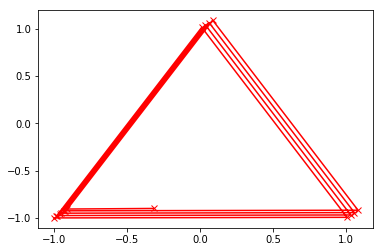

In [549]:
def overdraw_path(path, amount):
    out_x = np.copy(path.x).tolist()
    out_y = np.copy(path.y).tolist()
    remaining = amount
    while remaining > path.length():
        remaining -= path.length()
        out_x.extend(path.x)
        out_y.extend(path.y)
    for i, (p1, p2) in enumerate(zip(zip(path.x[:-1],path.y[:-1]), zip(path.x[1:],path.y[1:]))):
        #print(p1,p2)
        d = distance(p1, p2)
        #print("d =",d)
        if remaining > d:
            remaining -= d
            out_x.append(p2[0])
            out_y.append(p2[1])
        else:
            break
    #print("remaining =",remaining)
    if remaining > 0:
        #print("i =",i)
        n = len(path.x)
        last_x = out_x[-1]
        last_y = out_y[-1]
        next_x = path.x[(i+1)%n]
        next_y = path.y[(i+1)%n]
        d = float(np.hypot([next_x-last_x],[next_y-last_y]))
        x = np.interp(remaining, [0,d],[last_x, next_x])
        y = np.interp(remaining, [0,d],[last_y, next_y])
        out_x.append(x)
        out_y.append(y)
    return Path(out_x, out_y)

#path = path_coll.paths[12]
path = Path([-1,1,0,-1],[-1,-1,1,-1])
opat = overdraw_path(path, 20)

xx = np.asfarray(opat.x)
yy = np.asfarray(opat.y)
ii = np.linspace(0, 0.1, num=len(xx))
#ii = 0
plot(xx+ii, yy+ii, 'x-r');
#print("N =",len(xx))
np.vstack((xx,yy)).T
path.length()

In [550]:
from pipetools import pipe

In [551]:
def overdraw_path_coll(path_coll, amount):
    opaths = [overdraw_path(path, amount) for path in path_coll.paths]
    return PathCollection(opaths)

In [552]:
overdraw_amount = 0.5
prepare = pipe \
          | (lambda pc: overdraw_path_coll(pc, 0.5)) \
          | sort_path \
          | (lambda pc: pc.translate_to_origin()) \
          | (lambda pc: pc.translate(min(plater_xx), min(plater_yy))) \
          | (lambda pc: gen_gcode(pc.paths))
gcode_lines = list(prepare(path_coll))
with open('r2.gcode', 'w') as f:
    f.writelines(l+'\n' for l in gcode_lines)

array([[ 0.  , 20.  , 20.  ,  0.  ,  0.  , 20.  , 20.  ,  0.  ,  0.  ,
        20.  , 20.  ,  0.  ,  0.  , 20.  , 20.  ,  0.  ,  0.  , 20.  ,
        20.  ,  0.  ,  0.  , 20.  , 20.  ,  0.  ,  0.  , 20.  , 20.  ,
         0.  ,  0.  , 20.  , 20.  ,  0.  ,  0.  , 20.  , 20.  ,  0.  ,
         0.  , 20.  , 20.  ,  0.  ],
       [ 0.  ,  0.  ,  0.25,  0.25,  0.5 ,  0.5 ,  0.75,  0.75,  1.  ,
         1.  ,  1.25,  1.25,  1.5 ,  1.5 ,  1.75,  1.75,  2.  ,  2.  ,
         2.25,  2.25,  2.5 ,  2.5 ,  2.75,  2.75,  3.  ,  3.  ,  3.25,
         3.25,  3.5 ,  3.5 ,  3.75,  3.75,  4.  ,  4.  ,  4.25,  4.25,
         4.5 ,  4.5 ,  4.75,  4.75]])

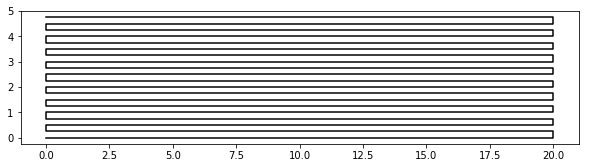

In [624]:
from itertools import repeat
def filling_pattern(width, height, delta):
    def gen():
        while True:
            yield [0,width]
            yield [width, 0]
    def gen2():
        y = 0
        while True:
            yield [y, y]
            #yield [y, y+delta]
            y += delta
    path = Path([], [])
    y = 0.0
    g = gen()
    g2 = gen2()
    while y < height:
        path.x.extend(next(g))
        path.y.extend(next(g2))
        y += delta
    return path

pattern = filling_pattern(20, 5, 0.25)
display([pattern])
np.vstack([pattern.x,pattern.y])

In [626]:
path_coll = PathCollection([pattern])
origin_x, origin_y = 60, 90
prepare = pipe \
          | (lambda pc: overdraw_path_coll(pc, 0.5)) \
          | sort_path \
          | (lambda pc: pc.translate_to_origin()) \
          | (lambda pc: pc.translate(origin_x, origin_y)) \
          | (lambda pc: gen_gcode(pc.paths))
            
gcode_lines = list(prepare(path_coll))
with open('fill.gcode', 'w') as f:
    f.writelines(l+'\n' for l in gcode_lines)